In [62]:
"""Multilayer Perceptron for drug response problem"""

from __future__ import division, print_function

import argparse
import csv
import logging
import sys
import json

import numpy as np

from keras import backend as K
from keras import metrics
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, LocallyConnected1D, Conv1D, MaxPooling1D, Flatten, Conv2D, LocallyConnected2D
from keras.callbacks import Callback, ModelCheckpoint, ProgbarLogger

# For non-interactive plotting
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


import p1b3 as benchmark
import candle

sys.argv = [''] # for Jupyter nbs

#cfg = K.tf.ConfigProto(gpu_options={'allow_growth': True})
#K.set_session(K.tf.Session(config=cfg))

'''
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
'''

## store results hpo
training_stats = {}
global tmp_stats

In [63]:
def initialize_parameters(default_model = 'p1b3_default_model.txt'):
    
    # Build benchmark object
    p1b3Bmk = benchmark.BenchmarkP1B3(benchmark.file_path, default_model, 'keras',
    prog='p1b3_baseline', desc='Multi-task (DNN) for data extraction from clinical reports - Pilot 3 Benchmark 1')
    
    
    # Initialize parameters
    gParameters = candle.finalize_parameters(p1b3Bmk)
    #benchmark.logger.info('Params: {}'.format(gParameters))

    return gParameters

def str2lst(string_val):
    result = [int(x) for x in string_val.split(' ')]
    return result


def evaluate_keras_metric(y_true, y_pred, metric):
    objective_function = metrics.get(metric)
    objective = objective_function(y_true, y_pred)
    return K.eval(objective)


def evaluate_model(model, generator, steps, metric, category_cutoffs=[0.]):
    y_true, y_pred = None, None
    count = 0
    while count < steps:
        x_batch, y_batch = next(generator)
        y_batch_pred = model.predict_on_batch(x_batch)
        y_batch_pred = y_batch_pred.ravel()
        y_true = np.concatenate((y_true, y_batch)) if y_true is not None else y_batch
        y_pred = np.concatenate((y_pred, y_batch_pred)) if y_pred is not None else y_batch_pred
        count += 1

    loss = evaluate_keras_metric(y_true.astype(np.float32), y_pred.astype(np.float32), metric)

    y_true_class = np.digitize(y_true, category_cutoffs)
    y_pred_class = np.digitize(y_pred, category_cutoffs)

    # theano does not like integer input
    acc = evaluate_keras_metric(y_true_class.astype(np.float32), y_pred_class.astype(np.float32), 'binary_accuracy')  # works for multiclass labels as well

    return loss, acc, y_true, y_pred, y_true_class, y_pred_class


def plot_error(y_true, y_pred, batch, file_ext, file_pre='output_dir', subsample=1000):
    if batch % 10:
        return

    total = len(y_true)
    if subsample and subsample < total:
        usecols = np.random.choice(total, size=subsample, replace=False)
        y_true = y_true[usecols]
        y_pred = y_pred[usecols]

    y_true = y_true * 100
    y_pred = y_pred * 100
    diffs = y_pred - y_true

    bins = np.linspace(-200, 200, 100)
    if batch == 0:
        y_shuf = np.random.permutation(y_true)
        plt.hist(y_shuf - y_true, bins, alpha=0.5, label='Random')

    #plt.hist(diffs, bins, alpha=0.35-batch/100., label='Epoch {}'.format(batch+1))
    plt.hist(diffs, bins, alpha=0.3, label='Epoch {}'.format(batch+1))
    plt.title("Histogram of errors in percentage growth")
    plt.legend(loc='upper right')
    plt.savefig(file_pre+'.histogram'+file_ext+'.b'+str(batch)+'.png')
    plt.close()

    # Plot measured vs. predicted values
    fig, ax = plt.subplots()
    plt.grid('on')
    ax.scatter(y_true, y_pred, color='red', s=10)
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.savefig(file_pre+'.diff'+file_ext+'.b'+str(batch)+'.png')
    plt.close()

In [64]:
class MyLossHistory(Callback):
    def __init__(self, progbar, val_gen, test_gen, val_steps, test_steps, metric, category_cutoffs=[0.], ext='', pre='save'):
        super(MyLossHistory, self).__init__()
        self.progbar = progbar
        self.val_gen = val_gen
        self.test_gen = test_gen
        self.val_steps = val_steps
        self.test_steps = test_steps
        self.metric = metric
        self.category_cutoffs = category_cutoffs
        self.pre = pre
        self.ext = ext

    def on_train_begin(self, logs={}):
        self.best_val_loss = np.Inf
        self.best_val_acc = -np.Inf

    def on_epoch_end(self, batch, logs={}):
        val_loss, val_acc, y_true, y_pred, y_true_class, y_pred_class = evaluate_model(self.model, self.val_gen, self.val_steps, self.metric, self.category_cutoffs)
        test_loss, test_acc, _, _, _, _ = evaluate_model(self.model, self.test_gen, self.test_steps, self.metric, self.category_cutoffs)
        self.progbar.append_extra_log_values([('val_acc', val_acc), ('test_loss', test_loss), ('test_acc', test_acc)])
        if float(logs.get('val_loss', 0)) < self.best_val_loss:
            plot_error(y_true, y_pred, batch, self.ext, self.pre)
        self.best_val_loss = min(float(logs.get('val_loss', 0)), self.best_val_loss)
        self.best_val_acc = max(float(logs.get('val_acc', 0)), self.best_val_acc)
        
        
    #def on_train_end(self, logs={}):
     #   training_stats[tmp_params] = tmp_stats




In [65]:
class MyProgbarLogger(ProgbarLogger):
    def __init__(self, samples):
        super(MyProgbarLogger, self).__init__(count_mode='samples')
        self.samples = samples

    def on_train_begin(self, logs=None):
        super(MyProgbarLogger, self).on_train_begin(logs)
        self.verbose = 1
        self.extra_log_values = []
        self.params['samples'] = self.samples

    def on_batch_begin(self, batch, logs=None):
        if self.seen < self.target:
            self.log_values = []
            self.extra_log_values = []

    def append_extra_log_values(self, tuples):
        for k, v in tuples:
            self.extra_log_values.append((k, v))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch_log = 'Epoch {}/{}'.format(epoch + 1, self.epochs)
        for k in self.params['metrics']:
            if k in logs:
                self.log_values.append((k, logs[k]))
                epoch_log += ' - {}: {:.4f}'.format(k, logs[k])
        for k, v in self.extra_log_values:
            self.log_values.append((k, v))
            epoch_log += ' - {}: {:.4f}'.format(k, float(v))
        if self.verbose:
            self.progbar.update(self.seen, self.log_values)
        benchmark.logger.debug(epoch_log)
        
        tmp_stats = epoch_log



In [66]:
def add_conv_layer(model, layer_params, input_dim=None, locally_connected=False):
    if len(layer_params) == 3: # 1D convolution
        filters = layer_params[0]
        filter_len = layer_params[1]
        stride = layer_params[2]
        if locally_connected:
            if input_dim:
                model.add(LocallyConnected1D(filters, filter_len, strides=stride, input_shape=(input_dim, 1)))
            else:
                model.add(LocallyConnected1D(filters, filter_len, strides=stride))
        else:
            if input_dim:
                model.add(Conv1D(filters, filter_len, strides=stride, input_shape=(input_dim, 1)))
            else:
                model.add(Conv1D(filters, filter_len, strides=stride))
    elif len(layer_params) == 5: # 2D convolution
        filters = layer_params[0]
        filter_len = (layer_params[1], layer_params[2])
        stride = (layer_params[3], layer_params[4])
        if locally_connected:
            if input_dim:
                model.add(LocallyConnected2D(filters, filter_len, strides=stride, input_shape=(input_dim, 1)))
            else:
                model.add(LocallyConnected2D(filters, filter_len, strides=stride))
        else:
            if input_dim:
                model.add(Conv2D(filters, filter_len, strides=stride, input_shape=(input_dim, 1)))
            else:
                model.add(Conv2D(filters, filter_len, strides=stride))
    return model




In [67]:
gParameters = initialize_parameters()
#gParameters['cell_features'] = 'all'
#gParameters['drug_features'] = 'all'
benchmark.check_params(gParameters)

Params:
{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 100,
 'category_cutoffs': [0.0],
 'cell_features': ['expression'],
 'cell_noise_sigma': 0.0,
 'data_type': <class 'numpy.float32'>,
 'dense': [1000, 500, 100, 50],
 'dropout': 0.1,
 'drug_features': ['descriptors'],
 'epochs': 1,
 'experiment_id': 'EXP000',
 'feature_subsample': 0,
 'initialization': 'normal',
 'learning_rate': 0.001,
 'logfile': None,
 'loss': 'mse',
 'max_logconc': -4.0,
 'min_logconc': -5.0,
 'optimizer': 'sgd',
 'output_dir': '/lustre/schandra_crpl/users/2216/NCI-DOE-Collab-Pilot1-Single-Drug-Response-Predictor/Pilot1/P1B3/save/EXP000/RUN000',
 'profiling': False,
 'rng_seed': 2017,
 'run_id': 'RUN000',
 'scaling': 'std',
 'scramble': False,
 'shuffle': False,
 'subsample': 'naive_balancing',
 'test_cell_split': 0.15,
 'timeout': -1,
 'train_bool': True,
 'val_split': 0.1,
 'verbose': None,
 'workers': 1}


In [68]:
def hpo(learning_rate, batch_size, epochs, dropout, activation, loss_measure, optimizer, folds):
    
    gParameters['learning_rate'] = learning_rate
    gParameters['batch_size'] = batch_size
    gParameters['epochs'] = epochs
    gParameters['dropout'] = dropout
    gParameters['activation'] = activation
    gParameters['optimizer'] = optimizer
    """
    Runs the model using the specified set of parameters

    Args:
       gParameters: a python dictionary containing the parameters (e.g. epoch)
       to run the model with.
    """
    #
    if 'dense' in gParameters:
        dval = gParameters['dense']
        if type(dval) != list:
            res = list(dval)
        #try:
            #is_str = isinstance(dval, basestring)
        #except NameError:
            #is_str = isinstance(dval, str)
        #if is_str:
            #res = str2lst(dval)
            gParameters['dense'] = res
        print(gParameters['dense'])

    if 'conv' in gParameters:
        flat = gParameters['conv']
        gParameters['conv'] = [flat[i:i+3] for i in range(0, len(flat), 3)]
        #conv_list = p1_common.parse_conv_list(gParameters['conv'])
        #cval = gParameters['conv']
        #try:
        #    is_str = isinstance(cval, basestring)
        #except NameError:
        #    is_str = isinstance(cval, str)
        #if is_str:
        #    res = str2lst(cval)
        #    gParameters['conv'] = res
        print('Conv input', gParameters['conv'])
    # print('Params:', gParameters)
    # Construct extension to save model
    ext = benchmark.extension_from_parameters(gParameters, '.keras')
    logfile = gParameters['logfile'] if gParameters['logfile'] else gParameters['output_dir']+ext+'.log'

    fh = logging.FileHandler(logfile)
    fh.setFormatter(logging.Formatter("[%(asctime)s %(process)d] %(message)s", datefmt="%Y-%m-%d %H:%M:%S"))
    fh.setLevel(logging.DEBUG)

    sh = logging.StreamHandler()
    sh.setFormatter(logging.Formatter(''))
    sh.setLevel(logging.DEBUG if gParameters['verbose'] else logging.INFO)

    benchmark.logger.setLevel(logging.DEBUG)
    benchmark.logger.addHandler(fh)
    benchmark.logger.addHandler(sh)
    benchmark.logger.info('Params: {}'.format(gParameters))

    # Get default parameters for initialization and optimizer functions
    kerasDefaults = candle.keras_default_config()
    seed = gParameters['rng_seed']

    # Build dataset loader object
    loader = benchmark.DataLoader(seed=seed, dtype=gParameters['data_type'],
                             val_split=gParameters['val_split'],
                             test_cell_split=gParameters['test_cell_split'],
                             cell_features=gParameters['cell_features'],
                             drug_features=gParameters['drug_features'],
                             feature_subsample=gParameters['feature_subsample'],
                             scaling=gParameters['scaling'],
                             scramble=gParameters['scramble'],
                             min_logconc=gParameters['min_logconc'],
                             max_logconc=gParameters['max_logconc'],
                             subsample=gParameters['subsample'],
                             category_cutoffs=gParameters['category_cutoffs'])

    # Initialize weights and learning rule
    initializer_weights = candle.build_initializer(gParameters['initialization'], kerasDefaults, seed)
    initializer_bias = candle.build_initializer('constant', kerasDefaults, 0.)

    activation = gParameters['activation']

    # Define model architecture
    gen_shape = None
    out_dim = 1

    model = Sequential()
    if 'dense' in gParameters: # Build dense layers
        for layer in gParameters['dense']:
            if layer:
                model.add(Dense(layer, input_dim=loader.input_dim,
                            kernel_initializer=initializer_weights,
                            bias_initializer=initializer_bias))
                if gParameters['batch_normalization']:
                    model.add(BatchNormalization())
                model.add(Activation(gParameters['activation']))
                if gParameters['dropout']:
                    model.add(Dropout(gParameters['dropout']))
    else: # Build convolutional layers
        gen_shape = 'add_1d'
        layer_list = list(range(0, len(gParameters['conv'])))
        lc_flag=False
        if 'locally_connected' in gParameters:
            lc_flag = True

        for l, i in enumerate(layer_list):
            if i == 0:
                add_conv_layer(model, gParameters['conv'][i], input_dim=loader.input_dim,locally_connected=lc_flag)
            else:
                add_conv_layer(model, gParameters['conv'][i],locally_connected=lc_flag)
            if gParameters['batch_normalization']:
                    model.add(BatchNormalization())
            model.add(Activation(gParameters['activation']))
            if gParameters['pool']:
                model.add(MaxPooling1D(pool_size=gParameters['pool']))
        model.add(Flatten())

    model.add(Dense(out_dim))

    # Define optimizer
    optimizer = candle.build_optimizer(gParameters['optimizer'],
                                                gParameters['learning_rate'],
                                                kerasDefaults)
    
    
    # Compile and display model
    model.compile(loss=gParameters['loss'], optimizer=optimizer)
    model.summary()
    benchmark.logger.debug('Model: {}'.format(model.to_json()))

    train_gen = benchmark.DataGenerator(loader, batch_size=gParameters['batch_size'], shape=gen_shape, name='train_gen', cell_noise_sigma=gParameters['cell_noise_sigma']).flow()
    val_gen = benchmark.DataGenerator(loader, partition='val', batch_size=gParameters['batch_size'], shape=gen_shape, name='val_gen').flow()
    val_gen2 = benchmark.DataGenerator(loader, partition='val', batch_size=gParameters['batch_size'], shape=gen_shape, name='val_gen2').flow()
    test_gen = benchmark.DataGenerator(loader, partition='test', batch_size=gParameters['batch_size'], shape=gen_shape, name='test_gen').flow()

    train_steps = int(loader.n_train/gParameters['batch_size'])
    val_steps = int(loader.n_val/gParameters['batch_size'])
    test_steps = int(loader.n_test/gParameters['batch_size'])

    if 'train_steps' in gParameters:
        train_steps = gParameters['train_steps']
    if 'val_steps' in gParameters:
        val_steps = gParameters['val_steps']
    if 'test_steps' in gParameters:
        test_steps = gParameters['test_steps']

    checkpointer = ModelCheckpoint(filepath=gParameters['output_dir']+'.model'+ext+'.h5', save_best_only=True)
    progbar = MyProgbarLogger(train_steps * gParameters['batch_size'])
    loss_history = MyLossHistory(progbar=progbar, val_gen=val_gen2, test_gen=test_gen,
                            val_steps=val_steps, test_steps=test_steps,
                            metric=gParameters['loss'], category_cutoffs=gParameters['category_cutoffs'],
                            ext=ext, pre=gParameters['output_dir'])
    
    # Seed random generator for training
    np.random.seed(seed)

    candleRemoteMonitor = candle.CandleRemoteMonitor(params=gParameters)

    history = model.fit_generator(train_gen, train_steps,
                        epochs=gParameters['epochs'],
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        verbose=0,
                        callbacks=[checkpointer, loss_history, progbar, candleRemoteMonitor],
                        )

    
    
    benchmark.logger.removeHandler(fh)
    benchmark.logger.removeHandler(sh)
    


In [70]:
learning_rates = [0.001, 0.01]
batch_sizes = [100, 50]
epochs = [5]
dropouts = [0.1, 0.6]
activations = ['relu']
optimizers = ['adam', 'sgd']

In [71]:
count = 1

for learning_rate in learning_rates:
    for optimizer in optimizers:
        for batch_size in batch_sizes:
            for dropout in dropouts:
                for activation in activations:
                    for epoch in epochs:
                        tmp_dict = {}
                        tmp_dict['Params'] = ['Learning Rate: {}'.format(learning_rate),
                                                           'Optimizer: {}'.format(optimizer),
                                                           'Batch Size: {}'.format(batch_size),
                                                           'Epochs: {}'.format(epoch),
                                                           'Dropout: {}'.format(dropout), 
                                                           'Activation: {}'.format(activation)]
                        tmp_stats = ''
                        hpo(learning_rate, batch_size, epoch, dropout, activation, loss_measure=None,
                            optimizer=optimizer, folds=None)
                        tmp_dict['stats'] = tmp_stats
                        training_stats[count] = tmp_dict
                        count += 1  

Params: {'dense': [1000, 500, 100, 50], 'batch_size': 100, 'epochs': 5, 'activation': 'relu', 'loss': 'mse', 'optimizer': 'adam', 'learning_rate': 0.001, 'scaling': 'std', 'dropout': 0.1, 'feature_subsample': 0, 'val_split': 0.1, 'rng_seed': 2017, 'initialization': 'normal', 'min_logconc': -5.0, 'max_logconc': -4.0, 'category_cutoffs': [0.0], 'test_cell_split': 0.15, 'cell_features': ['expression'], 'drug_features': ['descriptors'], 'subsample': 'naive_balancing', 'batch_normalization': False, 'cell_noise_sigma': 0.0, 'output_dir': '/lustre/schandra_crpl/users/2216/NCI-DOE-Collab-Pilot1-Single-Drug-Response-Predictor/Pilot1/P1B3/save/EXP000/RUN000', 'verbose': None, 'logfile': None, 'train_bool': True, 'experiment_id': 'EXP000', 'run_id': 'RUN000', 'shuffle': False, 'profiling': False, 'scramble': False, 'workers': 1, 'data_type': <class 'numpy.float32'>, 'timeout': -1}
Params: {'dense': [1000, 500, 100, 50], 'batch_size': 100, 'epochs': 5, 'activation': 'relu', 'loss': 'mse', 'optimiz

[1000, 500, 100, 50]


/lustre/schandra_crpl/users/2216/NCI-DOE-Collab-Pilot1-Single-Drug-Response-Predictor/Pilot1/P1B3/p1b3.py:533: ParserWarning: Both a converter and dtype were specified for column NAME - only the converter will be used
  converters ={'NAME' : str})
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
              GROWTH
count  261576.000000
mean        0.020341
std         1.002191
min       -10.276382
25%        -0.612788
50%         0.047490
75%         0.684798
max         5.276222
              GROWTH
count  261576.000000
mean        0.020341
std         1.002191
min       -10.276382
25%        -0.612788
50%         0.047490
75%         0.684798
max         5.276222
              GROWTH
count  261576.000000
mean        0.020341
std         1.002191
min       -10.276382
25%        -0.612788
50%         0.047490
75%       

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 1000)              23062000  
_________________________________________________________________
activation_93 (Activation)   (None, 1000)              0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_117 (Dense)            (None, 500)               500500    
_________________________________________________________________
activation_94 (Activation)   (None, 500)               0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 100)             

Params: {'dense': [1000, 500, 100, 50], 'batch_size': 100, 'epochs': 5, 'activation': 'relu', 'loss': 'mse', 'optimizer': 'adam', 'learning_rate': 0.001, 'scaling': 'std', 'dropout': 0.6, 'feature_subsample': 0, 'val_split': 0.1, 'rng_seed': 2017, 'initialization': 'normal', 'min_logconc': -5.0, 'max_logconc': -4.0, 'category_cutoffs': [0.0], 'test_cell_split': 0.15, 'cell_features': ['expression'], 'drug_features': ['descriptors'], 'subsample': 'naive_balancing', 'batch_normalization': False, 'cell_noise_sigma': 0.0, 'output_dir': '/lustre/schandra_crpl/users/2216/NCI-DOE-Collab-Pilot1-Single-Drug-Response-Predictor/Pilot1/P1B3/save/EXP000/RUN000', 'verbose': None, 'logfile': None, 'train_bool': True, 'experiment_id': 'EXP000', 'run_id': 'RUN000', 'shuffle': False, 'profiling': False, 'scramble': False, 'workers': 1, 'data_type': <class 'numpy.float32'>, 'timeout': -1}
Params: {'dense': [1000, 500, 100, 50], 'batch_size': 100, 'epochs': 5, 'activation': 'relu', 'loss': 'mse', 'optimiz

[1000, 500, 100, 50]


Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
/lustre/schandra_crpl/users/2216/NCI-DOE-Collab-Pilot1-Single-Drug-Response-Predictor/Pilot1/P1B3/p1b3.py:533: ParserWarning: Both a converter and dtype were specified for column NAME - only the converter will be used
  converters ={'NAME' : str})
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
              GROWTH
count  261576.000000
mean        0.020341
std         1.002191
min       -10.276382
25%        -0.612788
50%         0.047490
75%         0.684798
max         5.276222
              GROWTH
count  261576.000

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 1000)              23062000  
_________________________________________________________________
activation_97 (Activation)   (None, 1000)              0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_122 (Dense)            (None, 500)               500500    
_________________________________________________________________
activation_98 (Activation)   (None, 500)               0         
_________________________________________________________________
dropout_98 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 100)             

Params: {'dense': [1000, 500, 100, 50], 'batch_size': 50, 'epochs': 5, 'activation': 'relu', 'loss': 'mse', 'optimizer': 'adam', 'learning_rate': 0.001, 'scaling': 'std', 'dropout': 0.1, 'feature_subsample': 0, 'val_split': 0.1, 'rng_seed': 2017, 'initialization': 'normal', 'min_logconc': -5.0, 'max_logconc': -4.0, 'category_cutoffs': [0.0], 'test_cell_split': 0.15, 'cell_features': ['expression'], 'drug_features': ['descriptors'], 'subsample': 'naive_balancing', 'batch_normalization': False, 'cell_noise_sigma': 0.0, 'output_dir': '/lustre/schandra_crpl/users/2216/NCI-DOE-Collab-Pilot1-Single-Drug-Response-Predictor/Pilot1/P1B3/save/EXP000/RUN000', 'verbose': None, 'logfile': None, 'train_bool': True, 'experiment_id': 'EXP000', 'run_id': 'RUN000', 'shuffle': False, 'profiling': False, 'scramble': False, 'workers': 1, 'data_type': <class 'numpy.float32'>, 'timeout': -1}
Params: {'dense': [1000, 500, 100, 50], 'batch_size': 50, 'epochs': 5, 'activation': 'relu', 'loss': 'mse', 'optimizer

[1000, 500, 100, 50]


Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
Loaded 451169 unique (D, CL) response sets.
/lustre/schandra_crpl/users/2216/NCI-DOE-Collab-Pilot1-Single-Drug-Response-Predictor/Pilot1/P1B3/p1b3.py:533: ParserWarning: Both a converter and dtype were specified for column NAME - only the converter will be used
  converters ={'NAME' : str})
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
Distribution of dose response:
              GROWTH
count  261576.000000
mean        0.020341
std         1.002191
min       -10.276382
25%        -0.612788
50%         0.047490
75%         0.684798
max         5.276222
              GROWTH
count  261576.000000
mean        0.020341
std         1.00219

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 1000)              23062000  
_________________________________________________________________
activation_101 (Activation)  (None, 1000)              0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 1000)              0         
_________________________________________________________________
dense_127 (Dense)            (None, 500)               500500    
_________________________________________________________________
activation_102 (Activation)  (None, 500)               0         
_________________________________________________________________
dropout_102 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 100)             

KeyboardInterrupt: 

In [72]:
from datetime import datetime

now = datetime.now()

with open("hpo_run_" + str(now) + ".json", "w") as outfile:
    json.dump(training_stats, outfile)

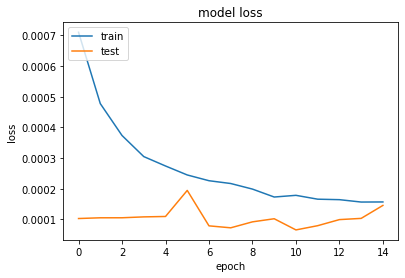

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [8]:
test_gen = benchmark.DataGenerator(loader, partition='test', batch_size=gParameters['batch_size'], shape=gen_shape, name='test_gen').flow()

In [9]:
test_steps = int(loader.n_test/gParameters['batch_size'])

In [10]:
if 'test_steps' in gParameters:
    test_steps = gParameters['test_steps']

In [ ]:
benchmark.logger.info('test_loss: {:.4f}'.format(test_loss))
benchmark.logger.info('test_acc: {:.4f}'.format(test_acc))
benchmark.logger.removeHandler(fh)
benchmark.logger.removeHandler(sh)    

In [ ]:
!pwd

In [6]:
import p1b3 as benchmark

In [7]:
cell_expr_path, cell_mrna_path, cell_prot_path, cell_kino_path,drug_desc_path, drug_auen_path, dose_resp_path, test_cell_path, test_drug_path = benchmark.stage_data()

In [8]:
dose_response_gdsc = benchmark.load_dose_response(dose_resp_path, seed, gParameters['data_type'],
                                min_logconc=gParameters['min_logconc'], max_logconc=gParameters['max_logconc'], subsample=gParameters['subsample'])

NameError: name 'seed' is not defined

In [11]:
dose_response_gdsc.head()

,CELLNAME,GROWTH,LOG_CONCENTRATION
GDSC,,,
1,ACH-000002,0.701901,4.834112
1,ACH-000002,0.705002,3.350517
1,ACH-000004,-1.656763,1.199252
1,ACH-000004,-1.655299,0.831239
1,ACH-000006,-0.318435,3.261706


In [17]:
loader.df_cell_expr

NameError: name 'loader' is not defined